# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


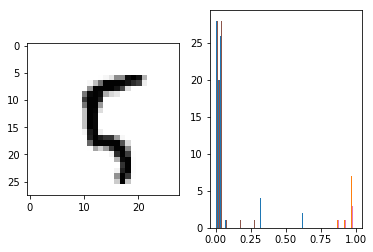

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[100]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

In [4]:
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell
#from tf.nn.rnn_cell import LSTMCell

In [5]:
learning_rate = 1e-3
num_epochs = 2
batch_size = 100
num_display = 100

def RNN(X):
    X = tf.unstack(X, num=28, axis = 1)
    lstm = LSTMCell(128, forget_bias = 0.9)
    outs, _ = tf.nn.static_rnn(lstm, X, dtype= tf.float32)
    return outs[-1]

# static_rnn, dynamic_rnn 
def get_model(X, by, is_reuse):
#    X = tf.expand_dims(X, axis=3) # (None, 28, 28, 1)
    outs = RNN(X)
    
    outs = tf.layers.dense(outs, 128)
    outs = tf.nn.relu(outs)
    outs = tf.layers.dense(outs, 10)
    one_hot = tf.one_hot(by, 10)

    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=outs, 
                                                      labels=one_hot)
    loss = tf.reduce_mean(loss)
    opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis=1), tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(by, preds), tf.float32))
    init = tf.global_variables_initializer()
    return {
        'loss': loss,
        'opt': opt,
        'preds': preds,
        'acc': acc,
        'init': init,
    }

In [6]:
X = tf.placeholder(tf.float32, shape=(None, 28, 28))
by = tf.placeholder(tf.int32)



In [7]:
model = get_model(X, by, False)
with tf.Session() as sess:
    sess.run(model['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch + 1))
        
        for ind_ in range(0, int(60000 / batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
            _, cur_loss, cur_acc = sess.run(
                [model['opt'], model['loss'], model['acc']],
                feed_dict={X: batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
    model['saver'].save(sess, './ours.ckpt')
                

InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8338604032

In [ ]:
model = get_model(X, by, True)

with tf.Session() as sess:
    sess.run(model['init'])
    model['saver'].restore(sess, './ours.ckpt')
    
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    for ind_ in range(0, 10):
        cur_loss, cur_acc = sess.run(
                    [model['loss'], model['acc']],
                    feed_dict={X: test_data[ind_*1000:(ind_+1)*1000], 
                               by: test_label[ind_*1000:(ind_+1)*1000]})
        cur_loss_all += cur_loss
        cur_acc_all += cur_acc
    print('TEST: loss {0:.4f} acc {1:.4f}'.format(cur_loss_all / 10.0, 
                                                  cur_acc_all / 10.0))